In [2]:
!pip install git+https://github.com/tensorflow/examples.git#egg=tensorflow-examples[model_maker]

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-install-ww5zjozh/tensorflow-examples
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-install-ww5zjozh/tensorflow-examples
     |████████████████████████████████| 323.0MB 43kB/s 
     |████████████████████████████████| 870kB 40.6MB/s 
     |████████████████████████████████| 1.1MB 43.7MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 266kB 43.8MB/s 
     |████████████████████████████████| 6.8MB 33.8MB/s 
     |████████████████████████████████| 460kB 44.7MB/s 
     |████████████████████████████████| 36.4MB 120kB/s 
     |████████████████████████████████| 174kB 48.3MB/s 
     |████████████████████████████████| 102kB 9.4MB/s 
     |████████████████████████████████| 358kB 43.4MB/s 
  Using cached https://files.pythonhosted.org/packages/89/e3/d576f6f02bc75bacbc3d42494e8f1d063c95617d86648dba243c2cb3963e/pybind11-2.5.0-py2.py3-none-any.whl
     |█

In [23]:
import numpy as np
import os

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
from tensorflow_examples.lite.model_maker.core.task.configs import QuantizationConfig
from tensorflow_examples.lite.model_maker.core.task.model_spec import mobilenet_v2_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import ImageModelSpec

import matplotlib.pyplot as plt

print('Imported successfully!')

Imported successfully!


In [55]:
# Unzipping files
!unzip ./dataset.zip

In [56]:
# Load data
data = ImageClassifierDataLoader.from_folder(os.path.join(os.getcwd(), 'dataset'))
train_data, test_data = data.split(0.9)

INFO:tensorflow:Load image with size: 108, num_label: 3, labels: nishikino_maki, sakurauchi_riko, takimoto_hifumi.


INFO:tensorflow:Load image with size: 108, num_label: 3, labels: nishikino_maki, sakurauchi_riko, takimoto_hifumi.


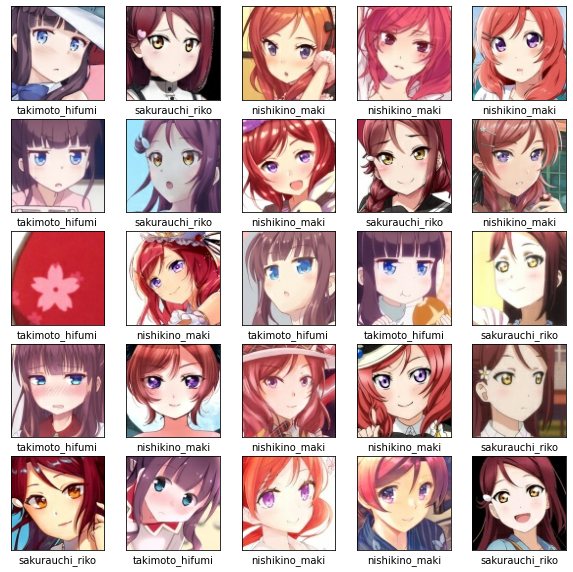

In [57]:
# Data Exploration
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.dataset.take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

In [59]:
# Customize the TensorFlow model
model = image_classifier.create(train_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_2 (HubK (None, 1280)              3413024   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843      
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
2/2 [==============================] - 2s 793ms/step - loss: 1.1645 - accuracy: 0.3906
Epoch 2/5
2/2 [==============================] - 2s 786ms/step - loss: 1.0537 - accuracy: 0.5469
Epoch 3/5
2/2 [==============================] - 2s 802ms/step - loss: 1.0612 - accuracy: 0.4062
Epoch 4/5
2/2 [==============================] - 2s 790ms/step - loss: 0.8

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_2 (HubK (None, 1280)              3413024   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843      
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________


In [61]:
# Model Evaluation
loss, accuracy = model.evaluate(test_data)
model.export(export_dir = os.getcwd())

4/4 [==============================] - 3s 782ms/step - loss: 0.6903 - accuracy: 0.8673
INFO:tensorflow:Assets written to: /tmp/tmpjfl_3fvy/assets


INFO:tensorflow:Assets written to: /tmp/tmpjfl_3fvy/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmprba20_tm/labels.txt.


INFO:tensorflow:Saving labels in /tmp/tmprba20_tm/labels.txt.


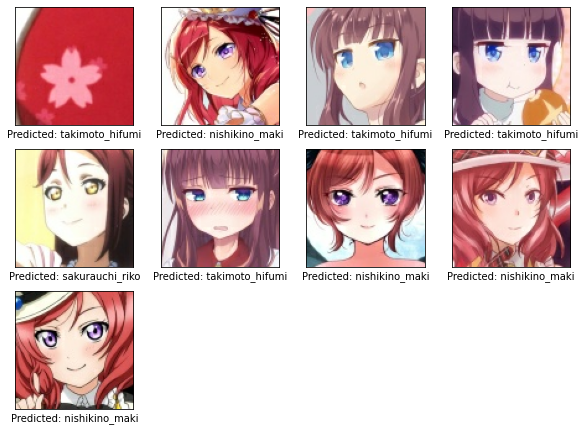

In [62]:
# A helper function that returns 'red'/'black' depending on if its two input parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 9 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test" dataset,
# Let's simply highlight it in red color.
plt.figure(figsize=(10, 10))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.dataset.take(9)):
  ax = plt.subplot(4, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()